step 1 run roscore to prevent losing of training data

step 2 roslaunch turtlebot3_gazebo turtlebot3_simple.launch

In [1]:
import rospy as ros
import os
from sensor_msgs.msg import LaserScan
import numpy as np
from numpy import Inf
from geometry_msgs.msg import Twist, Pose
from nav_msgs.msg import Odometry
from std_srvs.srv import Empty
from gazebo_msgs.srv import SpawnModel
import random
from math import atan2, pi
import matplotlib.pyplot as plt

Author: Abdulrahman Altahhan, Jan 2023.

The notebook use a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard python libraries (numpy, matplotlib etc.).
Please note that you will need to take a permission from the author to use the code for research, commercially or otherwise.

# Lesson 11: RL on Robotics

**Learning outcomes**
1. understand how to create a simple Robot environment that links to Gazebo
1. understand how to deal with the simulated environment in a grid world fashion
1. appreciate the intricacy of applying RL to the robotics domain
1. build on previous concepts to come up with a suitable solution to a problem at hand
1. understand how a replay buffer helps us to come closer to supervised learning and appreciate the important role it plays in reaching convergence
1. understand how to combine deep reinforcement learning with deep learning to create a powerful framework that allows automatic agent learning by observation or self-play.
1. understand how a replay buffer helps us to come closer to supervised learning and appreciate the important role it plays in reaching convergence for difficult problems that involve image processing and reinforcement learning


**Reading**:
We cover applications of RL on robotics based on previouse units which you can refere to.

In this notebook, we deal with how to set up a robot environment class that can handle the publish-subscribe on topics and deal with services in ROS. We must have ROS and Gazebo installed and set up on our machine. The code is a starting point and is not fully developed. You will need to write the necessary functionality to address a specific requirement. The main idea of tackling robotics applications in a Jupyter notebook is to utilise the provided infrastructure and libraries of code we covered in earlier units.

## Running Gazebo
You will need to launch a gazebo environment with Turtlebot3 in it. So long as the /scan(LaserScan), /odom (Odometry) and /cmd_vel(Twist) topics are available, the environment should work fine. Our target is to build an environment that will allow us to use the algorithms we developed in earlier units directly.

To launch an environment, you should open a terminal and run the following command

roslaunch turtlebot3_gazebo turtlebot3_house.launch

Note that you cannot do that here because that will block the notebook from executing other code. 
You must select restart your notebook kernel, ex. Kernel-> Restart and Run ALL, whenever you want to re-establish a connection with the environment.


In [2]:
%matplotlib inline

In [3]:
import rospy as ros
from sensor_msgs.msg import LaserScan
import numpy as np
from numpy import Inf
from geometry_msgs.msg import Twist
from nav_msgs.msg  import Odometry
from std_srvs.srv import Empty
import random
from math import pi

In [4]:
# global hyperparamter how many areas full cricle divided
θres = 10
# global hyperparamter how times publisher publisehs
hz = 5

In [77]:
class RoboGridEnv:
    
    # the goals default values are set just in front of the robot for testing, 
    # change according to the brief and as you see fit
    def __init__(self, xdim=4, ydim=4, hz=hz,  
                 xgoal=1.3, ygoal=0, tol=0.5,
                 x= -0.000021, y = -0.000021, θ=0,
                 speed=0.3, θspeed=1,
                 resol=3, θresol=2*pi/θres,
                 range_min=0.30,
                 rewards=[1000, -10, 0, -1,],
                 
                 visual=False):
        
        ros.init_node('RoboEnv')
        ros.loginfo('Robot Environment node has been created')
        
        self.sub_scan = ros.Subscriber('/scan', LaserScan, self.scan, queue_size=None)
        self.sub_odom = ros.Subscriber('/odom', Odometry, self.odom, queue_size=1)
        self.pub_robot = ros.Publisher('/cmd_vel', Twist, queue_size=1)
        
        self.Vstar = None # for compatibility
        
        #visual
        self.visual = visual
        
        # coordinates of the goal must be changed to match the given environment
        self.xgoal = xgoal
        self.ygoal = ygoal
        
        #size of env         
        self.xdim = xdim
        self.ydim = ydim
        
                 
        # $ rostopic hz /scan, rostopic hz /odom
        self.hz = hz  # frequency of scan
        self.rate = ros.Rate(self.hz)
        
        self.speed = speed    # linear speed, change as you see fit
        self.θspeed = θspeed # angular speed, change as you see fit
        self.tol = tol     # tolerance to goal recognition, within 2 feet
        
        self.resol = round(resol,2)
        self.θresol = round(θresol,2)
        
        self.cols = int(self.xdim//self.resol) +1
        self.rows = int(self.ydim//self.resol) +1
        self.orts = int(2*pi//self.θresol)     +1
        
        self.x = x
        self.y = y
        self.θ = θ
    
        self.nC = self.rows*self.cols           # Grid size
        self.nS = self.rows*self.cols*self.orts # State space size
        self.nA = 3
        
        self.range_max = 3.5
        self.range_min = 0.3  # change as you see fit
        
        print('Grid  size = ', self.rows,'x', self.cols,'=', self.nC)
        print('State size = ', self.rows,'x', self.cols, 'x', self.orts,'=',self.nS)
        
        self.robot = Twist()
        self.crashes = []
        self.crash = 0;

    # change as you see fit
    def scan(self, scans):
        scans = np.array(scans.ranges)
        scans[scans==Inf] = self.range_max
        self.scans = scans
    

    # change the reward to produce a suitable policy
    def reward(self):
        reward = -1
        done = False
        
        # cheacking for goal
        tol = self.tol 
        
        if self.xgoal + tol > self.x > self.xgoal - tol and self.ygoal + tol > self.y > self.ygoal - tol: 
            reward =  1000 
            done = True
            self.crashes.append(self.crash) 
            self.crash = 0
            
        if self.scans[:3].min() < self.range_min or self.scans[-3:].min() < self.range_min:
            reward =  -100 
            self.crash +=1
            self.reset()
            
        return reward, done
    
    # change as you see fit
    def odom(self, odoms):
        self.x = round(odoms.pose.pose.position.x, 1)   
        self.y = round(odoms.pose.pose.position.y, 1)   

        self.rate.sleep() 
    
    # change this to generate a suitable state representation
    def s_(self):
         # the return is provided for testing only
         # you must return the state of the robot instead
        return random.randint(0, self.nS)
    
    def reset(self):
#        reset_world service
        try:    ros.ServiceProxy('/gazebo/reset_world', Empty).call()
        except: print('could not reset world')
        self.rate.sleep()
        self.done = False
        return self.s_()

    def step(self, a):
        
        # commented out for testing
        if a==0: self.left(self.θspeed)
        if a==1: self.forward()
        if a==2: self.right(self.θspeed)
            
        self.s = self.s_() # get the stat
        self.r, self.done = self.reward()
        return self.s, self.r, self.done, {}
    
    def nodeslist(self):
        nodes = os.popen('rosnode list').readlines()
        for i in range(len(nodes)):
            nodes[i] = nodes[i].replace('\n', '')
            print(nodes[i])
    
    # for compatibility, no need to change
    def render(self, **kw):
        pass
    
    def left(self, θspeed):
        self.robot.linear.x  =  0
        self.robot.angular.z = θspeed
        self.pub_robot.publish(self.robot)
        self.rate.sleep()
    def forward(self):
        self.robot.linear.x  = self.speed
        self.robot.angular.z =  0
        self.pub_robot.publish(self.robot)
        self.rate.sleep()
    def right(self, θspeed):
        self.robot.linear.x  =  0
        self.robot.angular.z =-θspeed
        self.pub_robot.publish(self.robot)
        self.rate.sleep()
    def stop(self):
        self.robot.linear.x = 0
        self.robot.angular.z = 0
        self.pub_robot.publish(self.robot)
        self.rate.sleep()

In [78]:
robogrid2x2 = RoboGridEnv(xdim=4, ydim=4,
                          xgoal=1.5, ygoal=0, tol =0.8,
                          speed=0.3, θspeed=1.2, hz=hz,
                          resol=0.4, θresol=(2*pi/θres),
                          range_min=0.38)

[INFO] [1682692385.520579, 847.493000]: Robot Environment node has been created
Grid  size =  10 x 10 = 100
State size =  10 x 10 x 10 = 1000


In [37]:
def revolve(env):
    env.visual = True
    env.reset()
    env.step(-1)
    for i in range(20):
        env.step(0)
        env.stop()

    env.visual = False
revolve(robogrid2x2)

In [57]:
def straight(env):
    env.visual = True
#     env.reset()
    done = False
    
    while not done:
        done = env.step(1)[2]
    
    env.stop()
    env.visual= False
    
revolve(robogrid2x2)
# straight(robogrid2x2)

print(robogrid2x2.crashes)

[0, 0, 1, 1, 1, 1]


## Training Headless
To train more efficiently, turn off the gui in gazebo. To do so, go to the .launch file that you have launched gazebo with and set the values of gui and headless as follows:

    <arg name="gui" value="false"/>
    <arg name="headless" value="true"/>

Now it is time to apply Sarsa on robotics! Note that this will not generate a useful policy yet. You must adjust the above code and tune your RL method hyperparameters.

In [79]:
import nbimporter
from Lesson5_TemporalDifferenceMethods import *

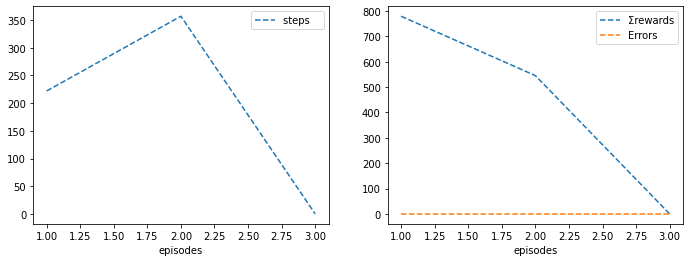

In [80]:
sarsa = Sarsa(env=robogrid2x2, α=0.3, episodes=40, seed=8, **demoGame()).interact()
robogrid2x2.stop()

In [81]:
robogrid2x2.crashes

[0, 1]

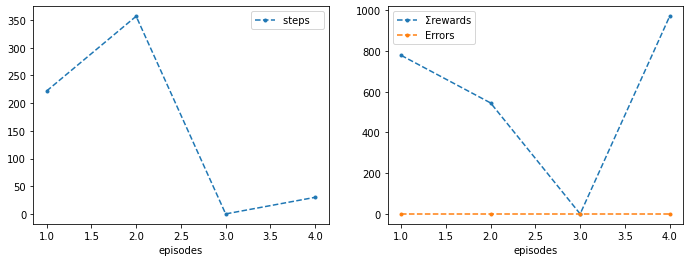

training was interrupted.......!


In [ ]:
sarsa.interact(resume=True)
robogrid2x2.stop()

In [1]:
sarsa.episodes = 100
%time sarsa.interact(resume=True)
# robogrid2x2.stop()

NameError: name 'sarsa' is not defined

Continue by adding more cells to address the requirements